In [7]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST

from torchvision import transforms as transforms

!pip install torch_snippets
from torch_snippets import *

device = "cuda" if torch.cuda.is_available() else "cpu"


BATCH_SIZE = 32
LR = 1e-3

In [8]:
img_transformation = transforms.Compose([
    transforms.ToTensor(),
])

train_ds = MNIST("data",train=True,download=True,transform=img_transformation)
val_ds = MNIST("data",train=False,download=False,transform=img_transformation)

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)


In [30]:
import torch.nn.functional as F

class VAE(nn.Module):
  def __init__(self,x_dim,h_dim1,h_dim2,z_dim):
    super().__init__()


    self.d1 = nn.Linear(x_dim,h_dim1)
    self.d2 = nn.Linear(h_dim1,h_dim2)
    self.d31 = nn.Linear(h_dim2,z_dim)
    self.d32 = nn.Linear(h_dim2,z_dim)
    self.d4 = nn.Linear(z_dim,h_dim2)
    self.d5 = nn.Linear(h_dim2,h_dim1)
    self.d6 = nn.Linear(h_dim1,x_dim)

  def encoder(self,x):
    h = F.relu(self.d1(x))
    h = F.relu(self.d2(h))
    return self.d31(h), self.d32(h)

  def sampling (self,mean,log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mean)

  def decoder(self,z):
    h = F.relu(self.d4(z))
    h = F.relu(self.d5(h))
    return F.sigmoid(self.d6(h))


  def forward(self,x):
    mean,log_var = self.encoder(x.view(-1,784))
    z = self.sampling(mean,log_var)
    return self.decoder(z), mean, log_var

In [31]:
def train_batch(data,model,optimizer,loss_function):
  model.train()
  data = data.to(device)
  optimizer.zero_grad()
  recon_batch,mean,log_var = model(data)

  loss,mse,kld = loss_function(recon_batch,data,mean,log_var)
  loss.backward()
  optimizer.step()

  return loss,mse,kld,log_var.mean(),mean.mean()

def val_batch(data,model,loss_function):
  model.eval()
  data = data.to(device)
  recon_batch,mean,log_var = model(data)

  loss,mse,kld = loss_function(recon_batch,data,mean,log_var)

  return loss,mse,kld,log_var.mean(),mean.mean()

def loss_fn ( recon_x,x,mean,log_var):
    RECON = F.mse_loss(recon_x,x.view(-1,784),reduction="sum")
    KLD = -0.5*torch.sum(1+log_var-mean.pow(2)-log_var.exp())

    return RECON+KLD,RECON,KLD

In [32]:
vae = VAE(x_dim=784,h_dim1=512,h_dim2=256,z_dim=50).to(device)
optimizer = torch.optim.Adam(vae.parameters(),lr=LR)

EPOCH: 1.000  val_loss: 1033.961  train_recon: 826.276  train_kld: 251.112  val_recon: 763.130  val_log_var: -0.331  val_kld: 270.831  train_loss: 1077.388  val_mean: -0.000  train_log_var: -0.310  train_mean: -0.001  (15.79s - 142.10s remaining)


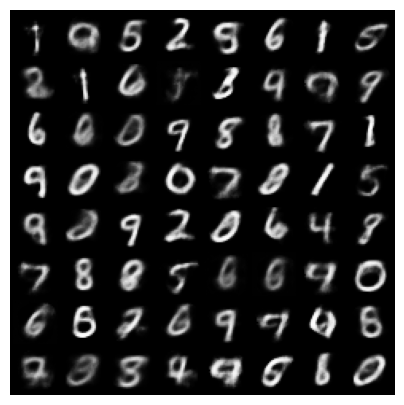

EPOCH: 2.000  val_loss: 1003.395  train_recon: 751.167  train_kld: 271.751  val_recon: 720.707  val_log_var: -0.352  val_kld: 282.688  train_loss: 1022.917  val_mean: -0.003  train_log_var: -0.338  train_mean: -0.001  (30.98s - 123.91s remaining)


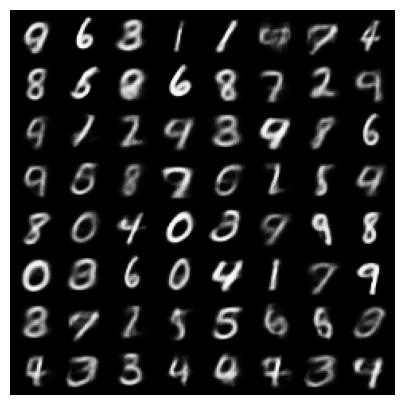

EPOCH: 3.000  val_loss: 992.393  train_recon: 715.513  train_kld: 281.437  val_recon: 702.934  val_log_var: -0.358  val_kld: 289.460  train_loss: 996.950  val_mean: -0.007  train_log_var: -0.351  train_mean: -0.001  (46.44s - 108.36s remaining)


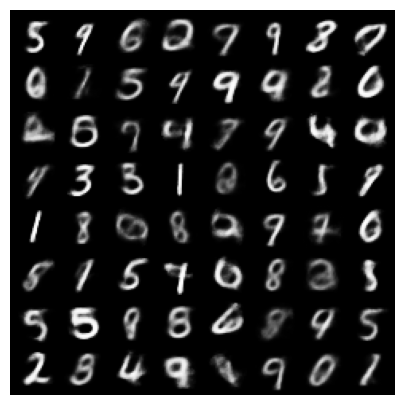

EPOCH: 4.000  val_loss: 968.143  train_recon: 692.643  train_kld: 288.205  val_recon: 678.112  val_log_var: -0.363  val_kld: 290.031  train_loss: 980.849  val_mean: -0.008  train_log_var: -0.360  train_mean: -0.000  (62.03s - 93.05s remaining)


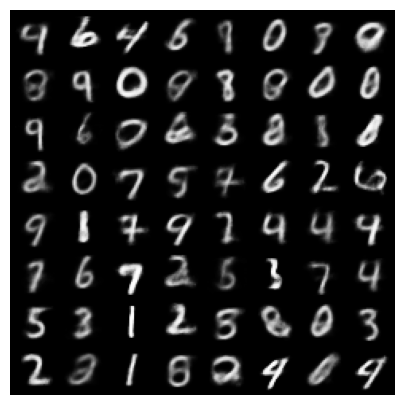

EPOCH: 5.000  val_loss: 960.567  train_recon: 671.995  train_kld: 294.543  val_recon: 666.234  val_log_var: -0.368  val_kld: 294.332  train_loss: 966.538  val_mean: -0.012  train_log_var: -0.368  train_mean: -0.000  (78.35s - 78.35s remaining)


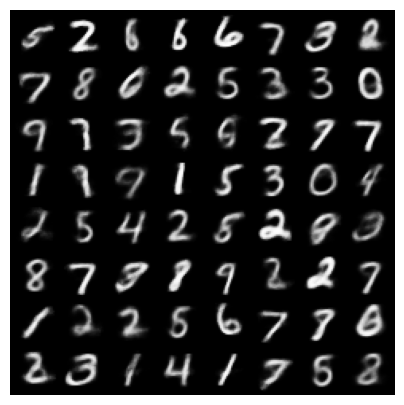

EPOCH: 6.000  val_loss: 949.292  train_recon: 653.773  train_kld: 300.859  val_recon: 655.622  val_log_var: -0.365  val_kld: 293.670  train_loss: 954.633  val_mean: -0.007  train_log_var: -0.376  train_mean: -0.000  (93.83s - 62.55s remaining)


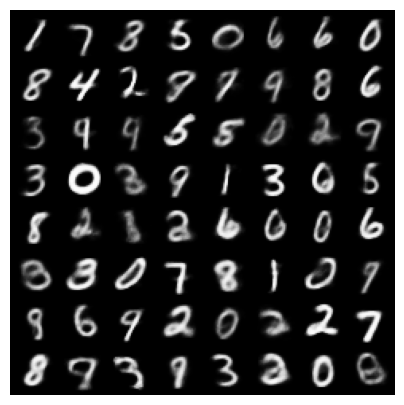

EPOCH: 7.000  val_loss: 940.383  train_recon: 641.091  train_kld: 305.279  val_recon: 635.992  val_log_var: -0.384  val_kld: 304.391  train_loss: 946.370  val_mean: -0.006  train_log_var: -0.382  train_mean: -0.000  (109.00s - 46.71s remaining)


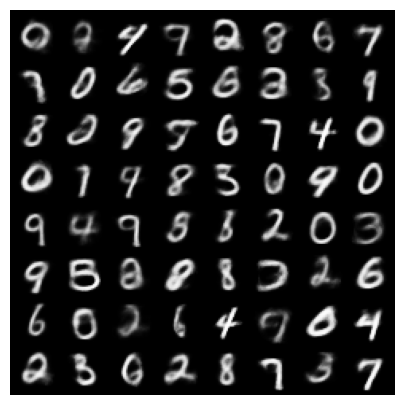

EPOCH: 8.000  val_loss: 938.776  train_recon: 631.189  train_kld: 308.101  val_recon: 638.013  val_log_var: -0.377  val_kld: 300.763  train_loss: 939.290  val_mean: -0.004  train_log_var: -0.386  train_mean: -0.001  (124.59s - 31.15s remaining)


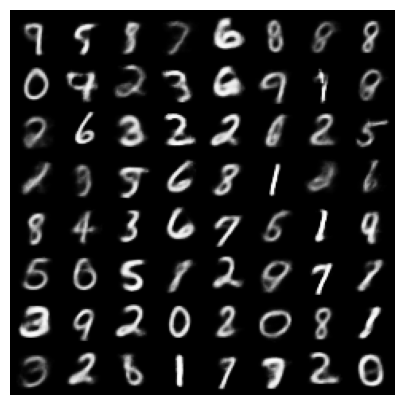

EPOCH: 9.000  val_loss: 934.869  train_recon: 623.024  train_kld: 311.037  val_recon: 617.652  val_log_var: -0.394  val_kld: 317.218  train_loss: 934.061  val_mean: -0.005  train_log_var: -0.390  train_mean: -0.000  (139.78s - 15.53s remaining)


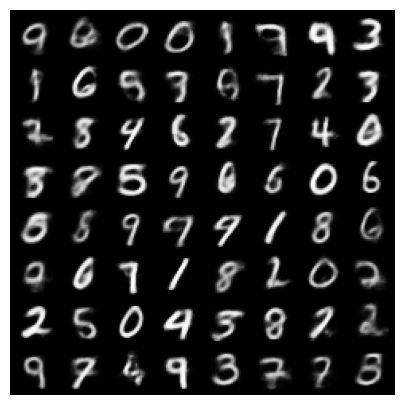

EPOCH: 10.000  val_loss: 928.855  train_recon: 616.182  train_kld: 313.312  val_recon: 606.947  val_log_var: -0.403  val_kld: 321.908  train_loss: 929.494  val_mean: -0.008  train_log_var: -0.393  train_mean: -0.000  (155.04s - 0.00s remaining)


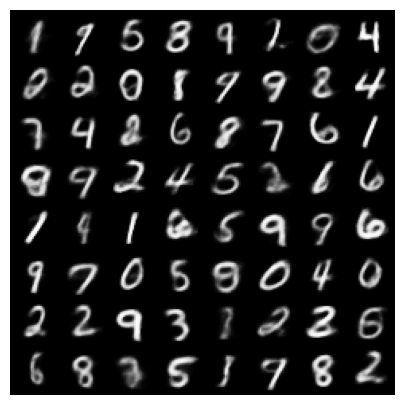

100%|██████████| 111/111 [00:00<00:00, 197.85it/s]


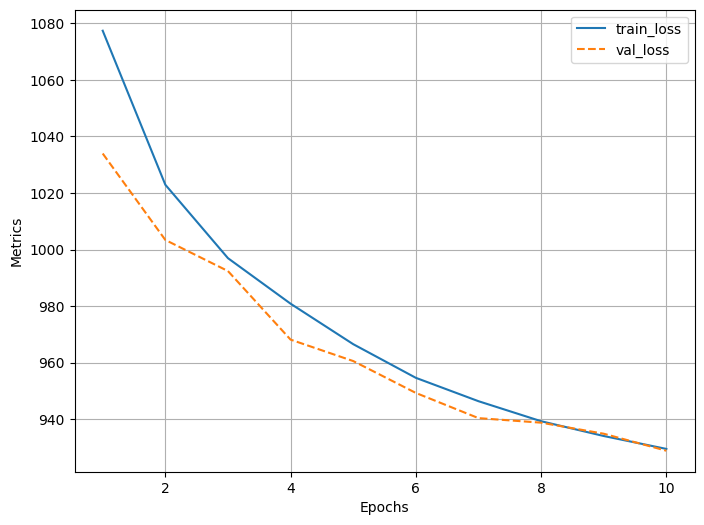

In [34]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
  N = len(train_dl)

  for ix , (data,_) in enumerate(train_dl):
    loss,recon,kld,log_var,mean= train_batch(data,vae,optimizer,loss_fn)
    pos = epoch + (1 + ix)/N
    log.record(pos,train_loss = loss,train_kld=kld,train_recon=recon,train_log_var =log_var,train_mean=mean,end='\r')

  N = len(val_dl)
  with torch.inference_mode():
    for ix,(data,_) in enumerate(val_dl):
        loss,recon,kld,log_var,mean= val_batch(data,vae,loss_fn)
        pos = epoch + (1 + ix)/N
        log.record(pos,val_loss = loss,val_kld=kld,val_recon=recon,val_log_var =log_var,val_mean=mean,end='\r')

  log.report_avgs(epoch+1)

  with torch.inference_mode():
    z = torch.randn(64,50).to(device)
    sample = vae.decoder(z).to(device)
    images = torchvision.utils.make_grid(sample.view(64,1,28,28)).permute(1,2,0)
    show(images)

log.plot_epochs(['train_loss','val_loss'])


